# Cloud Optimized Geotiff Overview Resampling

When making cloud optimized geotiffs you can select the resampling method used to generate the overviews. This is most important when using software that renders from overviews (e.g QGIS, ArcGIS), particularly web tilers like Titiler. Different types of data can drastically change appearance when more zoomed out based on the method selected.

This notebook will loop over the resampling methods available in gdal 

In [4]:
# Requires gdal >= 3.2 for Overview Resampling to work
# RMS resampling was added in GDAL 3.3
#!pip install -q -U rasterio>=1.2.3 folium
!mamba create -n gdal34 -c conda-forge gdal==3.4.3 rasterio rio-cogeo ipykernel

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [6]:
import rasterio as rio
from rasterio.session import AWSSession
from rasterio.plot import show
import boto3
import subprocess

In [2]:
!gdalinfo --version

GDAL 3.4.3, released 2022/04/22


In [ ]:
#use rasterio to read the same file full res and overiew levels, plot side by side
#with func compare the different products and a sampling of tiles
# try alternative overview resampling methods to find better solution

In [3]:
tile = '/projects/tmp/boreal/boreal_agb_202206061654544252_0076.tif'

In [5]:
!gdalinfo {tile}

Driver: GTiff/GeoTIFF
Files: /projects/tmp/boreal/boreal_agb_202206061654544252_0076.tif
       /projects/tmp/boreal/boreal_agb_202206061654544252_0076.tif.aux.xml
Size is 3000, 3000
Coordinate System is:
BOUNDCRS[
    SOURCECRS[
        PROJCRS["unknown",
            BASEGEOGCRS["unknown",
                DATUM["Unknown_based_on_GRS80_ellipsoid",
                    ELLIPSOID["GRS 1980",6378137,298.257222101004,
                        LENGTHUNIT["metre",1],
                        ID["EPSG",7019]]],
                PRIMEM["Greenwich",0,
                    ANGLEUNIT["degree",0.0174532925199433,
                        ID["EPSG",9122]]]],
            CONVERSION["Albers Equal Area",
                METHOD["Albers Equal Area",
                    ID["EPSG",9822]],
                PARAMETER["Latitude of false origin",40,
                    ANGLEUNIT["degree",0.0174532925199433],
                    ID["EPSG",8821]],
                PARAMETER["Longitude of false origin",180,
            

In [35]:
def compare_overviews(image):
    '''
    Read the original data, and overviews an plot them.
    TODO: limit the size of data read
    image = the path to input COG to read
    '''
    aws_session = AWSSession(boto3.Session())
    with rio.Env(aws_session):
        with rio.open(image, 'r') as src:
            oviews = src.overviews(1)
            #len of oviews + 1
            # generate object names to match
            # creat a plot of oviews +1 axes/columns
            # plot to each
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
            ax_list = [ax1, ax2, ax3, ax4]
            #fig = plt.figure()
            show(src, ax=ax_list[0])
            k = 1
            for oview in oviews:
                thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
                show(thumbnail, ax=ax_list[k])
                k += 1

    return axs

def generate_overview(orig, method):
    ''' 
    Create a copy of original GeoTiff as COG with different overview resampling method
    orig = the original GeotTiff
    method = the resampling method
    return the path to the new file
    '''
    outfile = f'/projects/local_data/{method}.tif'
    process = subprocess.run(['gdal_translate', '-of', 'COG',
                              '-co', f'OVERVIEW_RESAMPLING={method}',
                              '-co', 'COMPRESS=Deflate',
                              f'{orig}', f'{outfile}'
                             ], 
                         stdout=subprocess.PIPE, 
                         universal_newlines=True)
    print(process)

    return outfile

In [19]:
resample_methods = ["AVERAGE", "NEAREST", "BILINEAR", "CUBIC", "CUBICSPLINE", "LANCZOS", "MODE", "RMS"]


In [21]:
#rms = '/projects/local_data/rms.tif'
files = [generate_overview(tile, method) for method in resample_methods] 

CompletedProcess(args=['gdal_translate', '-of', 'COG', '-co', 'OVERVIEW_RESAMPLING=AVERAGE', '-co', 'COMPRESS=Deflate', '/projects/tmp/boreal/boreal_agb_202206061654544252_0076.tif', '/projects/local_data/AVERAGE.tif'], returncode=0, stdout='Input file size is 3000, 3000\n0...10...20...30...40...50...60...70...80...90...100 - done.\n')
CompletedProcess(args=['gdal_translate', '-of', 'COG', '-co', 'OVERVIEW_RESAMPLING=NEAREST', '-co', 'COMPRESS=Deflate', '/projects/tmp/boreal/boreal_agb_202206061654544252_0076.tif', '/projects/local_data/NEAREST.tif'], returncode=0, stdout='Input file size is 3000, 3000\n0...10...20...30...40...50...60...70...80...90...100 - done.\n')
CompletedProcess(args=['gdal_translate', '-of', 'COG', '-co', 'OVERVIEW_RESAMPLING=BILINEAR', '-co', 'COMPRESS=Deflate', '/projects/tmp/boreal/boreal_agb_202206061654544252_0076.tif', '/projects/local_data/BILINEAR.tif'], returncode=0, stdout='Input file size is 3000, 3000\n0...10...20...30...40...50...60...70...80...90...

In [22]:
files

['/projects/local_data/AVERAGE.tif',
 '/projects/local_data/NEAREST.tif',
 '/projects/local_data/BILINEAR.tif',
 '/projects/local_data/CUBIC.tif',
 '/projects/local_data/CUBICSPLINE.tif',
 '/projects/local_data/LANCZOS.tif',
 '/projects/local_data/MODE.tif',
 '/projects/local_data/RMS.tif']

In [23]:
import matplotlib.pyplot as plt

[array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object),
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object)]

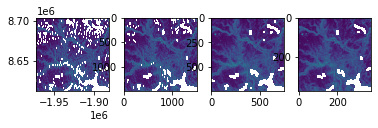

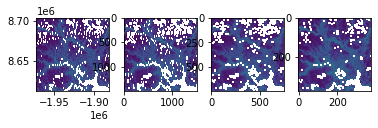

In [37]:
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
#ax_list = [ax1, ax2, ax3, ax4]
[compare_overviews(file) for file in files[0:2]]